In [10]:
import tensorflow as tf 
import numpy as np
import pandas as pd
from keras.layers import Flatten,concatenate,Dense,Lambda,Dropout
from keras.layers import Input
from keras.models import Model
from keras.utils.vis_utils import plot_model
import matplotlib.pyplot as plt
from keras.optimizers import RMSprop
from keras import backend as K
import random

### 划分数据集

In [11]:
path = "./UJIIndoorLoc/children_13/sorted/00_sorted.csv"
train_df = pd.read_csv(path,header=0)
print(train_df.shape)
a = train_df.mean()
print(a["WAP004"])
for i in train_df.columns[:520]:
    if a[i]==-110:
        del train_df[i]
print(train_df.shape)
train_df["REF"] = pd.factorize(train_df["REF"])[0].astype(int)#将标签映射到顺序数字上
labels = train_df.REF.values
features = train_df.drop(columns=['TIMESTAMP','PHONEID','USERID','RELATIVEPOSITION',
                                'SPACEID','BUILDINGID','FLOOR','LATITUDE','LONGITUDE',
                                'BF','REF']).values
features,labels,features.shape

(1059, 531)
(1059, 130)


(array([[-110, -110, -110, ..., -110, -110, -110],
        [-110, -110, -110, ..., -110, -110, -110],
        [-110, -110, -110, ..., -110, -110, -110],
        ...,
        [-110, -110, -110, ..., -110, -110, -110],
        [-110, -110, -110, ..., -110, -110, -110],
        [-110, -110, -110, ..., -110, -110, -110]], dtype=int64),
 array([ 0,  0,  0, ..., 53, 53, 53]),
 (1059, 119))

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
X_train, X_test, Y_train, Y_test = train_test_split(features, 
                                                    labels, 
                                                    test_size=0.3,
                                                    random_state= 150,
                                                    #random_state：可以理解为随机数种子，主要是为了复现结果而设置
                                                    stratify=labels)#保证划分的test中的所有标签齐全
X_train,Y_train = shuffle(X_train, Y_train)
Y_train,Y_test

(array([48, 26,  5, 32, 32, 16, 46, 42,  0, 32,  8, 12, 45, 33, 20,  4, 10,
         2, 30, 49, 40,  5, 44, 22, 10,  3,  0,  0, 29, 39, 15, 26,  2, 25,
        14, 12, 33, 46, 13, 39, 41, 25, 32, 28, 27, 11, 24, 35, 45, 44, 17,
        39, 53, 12, 37, 12, 33, 15, 12, 49, 37, 46, 52, 42, 21, 25, 26,  3,
        52, 34, 35, 19, 26, 20, 23,  4, 17, 33,  6, 39, 36, 25, 53, 23, 29,
        15, 16, 13, 37, 27, 30, 16, 25, 36, 45,  8, 31,  5, 12, 51, 51, 52,
        44,  1, 20, 40, 34, 18, 40, 19, 43,  9,  0, 19, 27, 30, 31, 13, 15,
        45, 27, 39, 39, 22, 18, 17, 13, 30, 13,  5, 13, 23, 48, 26, 41, 29,
        17, 53, 22, 20,  8, 46,  6, 42, 17, 44,  3, 49, 42, 30, 26, 17, 46,
        28, 14,  0, 34, 30, 26,  4, 47, 21, 31, 34, 16, 21, 35, 33, 35, 15,
        33,  1, 29, 32, 23, 16, 24, 51, 27, 33, 26,  4, 42, 17,  8, 16, 22,
        15, 28, 22, 25, 25, 38, 42, 12, 19, 40, 11, 25, 13, 37, 45, 11, 27,
         9, 36, 29, 11,  7, 17, 52,  7, 50, 24, 35, 19, 18, 50, 12,  1, 34,
        13, 

In [14]:
from sklearn.preprocessing import StandardScaler
from keras.utils import to_categorical
scale = StandardScaler().fit(X_train)
X_train_transform = scale.transform(X_train)
X_test_transform = scale.transform(X_test)
Y_train_encoded = to_categorical(Y_train)
Y_test_encoded = to_categorical(Y_test)
input_dim = features.shape[1:]
input_dim

(119,)

### 定义特征提取网络

In [6]:
from keras.models import Model
def featureNet(input_dim):
    inp = Input(shape=input_dim ,name = 'ap_feature')
    model = Dense(1024,activation='relu')(inp)
    model = Dense(512,activation='relu')(model)
    model = Dense(256,activation='relu')(model)
    output = Dense(119,activation='relu')(model)
    return Model(inp,output)

In [7]:
def euclidean_distance(vects):
    x, y = vects
    return K.sqrt(K.sum(K.square(x - y), axis=1, keepdims=True))


def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

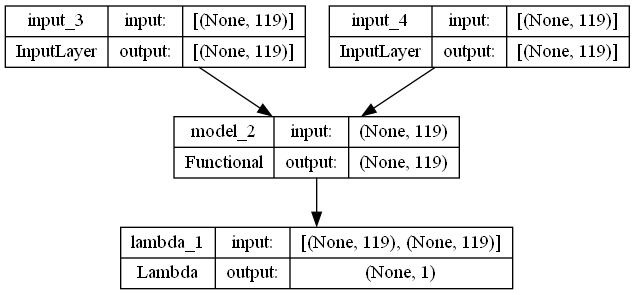

In [9]:
import keras
base_network = featureNet(input_dim)
input_a = Input(shape=input_dim)
input_b = Input(shape=input_dim)

# because we re-use the same instance`base_network`,
# the weights of the network
# will be shared across the two branches
processed_a = base_network(input_a)
processed_b = base_network(input_b)

distance = Lambda(euclidean_distance, output_shape=eucl_dist_output_shape)([processed_a, processed_b])

model = Model(inputs=[input_a, input_b], outputs=distance)
keras.utils.plot_model(model,"Siamese_Model.png",show_shapes=True)

In [53]:
def contrastive_loss(y_true, y_pred):
    '''Contrastive loss from Hadsell-et-al.'06
    http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    '''
    margin = 1
    return K.mean(y_true * K.square(y_pred) + (1 - y_true) * K.square(K.maximum(margin - y_pred, 0)))

### 创建正负样本对

In [54]:
def create_pairs(x,digit_indices):
    pairs = []
    labels = []
    #这里n是所有类别的样本数目的最小值再减1
    n = min([len(digit_indices[d]) for d in range(54)]) - 1
    for d in range(54):
        for i in range(n):
            # 遍历d类的样本，取临近的两个样本为正样本对
            z1, z2 = digit_indices[d][i], digit_indices[d][i+1]
            pairs += [[x[z1], x[z2]]]
            # randrange会产生1~9之间的随机数，含1和9
            inc = random.randrange(1, 10)
            # (d+inc)%10一定不是d，用来保证负样本对的图片绝不会来自同一个类
            dn = (d + inc) % 10
            # 在d类和dn类中分别取i样本构成负样本对
            z1, z2 = digit_indices[d][i], digit_indices[dn][i]
            pairs += [[x[z1], x[z2]]]
            # 添加正负样本标签
            labels += [1.0, 0.0] #标签一定使用浮点数，不然会报错
    return np.array(pairs), np.array(labels)

In [55]:
digit_indices = [np.where(Y_train == i)[0] for i in range(54)]
tr_pairs, tr_y = create_pairs(X_train_transform, digit_indices)

digit_indices = [np.where(Y_test == i)[0] for i in range(54)]
te_pairs, te_y = create_pairs(X_test_transform, digit_indices)

In [56]:
def compute_accuracy(predictions, labels):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    return labels[predictions.ravel() < 0.5].mean()

In [57]:
tr_pairs[:, 0],tr_pairs[:, 1],tr_y

(array([[-0.50679351, -0.13210547, -0.15448632, ..., -0.21598904,
         -0.03676073, -0.03676073],
        [-0.50679351, -0.13210547, -0.15448632, ..., -0.21598904,
         -0.03676073, -0.03676073],
        [-0.50679351, -0.13210547, -0.15448632, ..., -0.21598904,
         -0.03676073, -0.03676073],
        ...,
        [-0.50679351, -0.13210547, -0.15448632, ..., -0.21598904,
         -0.03676073, -0.03676073],
        [-0.50679351, -0.13210547, -0.15448632, ..., -0.21598904,
         -0.03676073, -0.03676073],
        [-0.50679351, -0.13210547, -0.15448632, ..., -0.21598904,
         -0.03676073, -0.03676073]]),
 array([[-0.50679351, -0.13210547, -0.15448632, ..., -0.21598904,
         -0.03676073, -0.03676073],
        [-0.50679351, -0.13210547, -0.15448632, ..., -0.21598904,
         -0.03676073, -0.03676073],
        [-0.50679351, -0.13210547, -0.15448632, ..., -0.21598904,
         -0.03676073, -0.03676073],
        ...,
        [-0.50679351, -0.13210547, -0.15448632, ..., -

In [58]:
from keras.optimizers import Adam
rms = RMSprop()
model.compile(loss=contrastive_loss, optimizer=rms)
model.fit([tr_pairs[:, 0], tr_pairs[:, 1]], tr_y,
          validation_data=([te_pairs[:, 0], te_pairs[:, 1]], te_y),
          batch_size=64,
          epochs=50,
          verbose=1)

# compute final accuracy on training and test sets
pred = model.predict([tr_pairs[:, 0], tr_pairs[:, 1]])
tr_acc = compute_accuracy(pred, tr_y)
pred = model.predict([te_pairs[:, 0], te_pairs[:, 1]])
te_acc = compute_accuracy(pred, te_y)

print('* Accuracy on training set: %0.2f%%' % (100 * tr_acc))
print('* Accuracy on test set: %0.2f%%' % (100 * te_acc))

Epoch 1/50
11/11 [==============================] - 1s 36ms/step - loss: 0.2699 - val_loss: 0.1191
Epoch 2/50
11/11 [==============================] - 0s 23ms/step - loss: 0.0858 - val_loss: 0.0902
Epoch 3/50
11/11 [==============================] - 0s 22ms/step - loss: 0.0581 - val_loss: 0.0843
Epoch 4/50
11/11 [==============================] - 0s 22ms/step - loss: 0.0528 - val_loss: 0.1801
Epoch 5/50
11/11 [==============================] - 0s 22ms/step - loss: 0.0791 - val_loss: 0.0754
Epoch 6/50
11/11 [==============================] - 0s 23ms/step - loss: 0.0485 - val_loss: 0.0643
Epoch 7/50
11/11 [==============================] - 0s 23ms/step - loss: 0.0380 - val_loss: 0.0550
Epoch 8/50
11/11 [==============================] - 0s 29ms/step - loss: 0.0307 - val_loss: 0.0973
Epoch 9/50
11/11 [==============================] - 0s 22ms/step - loss: 0.0415 - val_loss: 0.0472
Epoch 10/50
11/11 [==============================] - 0s 24ms/step - loss: 0.0285 - val_loss: 0.0566
Epoch 11/